In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunlingge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from imblearn.under_sampling import RandomUnderSampler

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [5]:
data = pd.read_csv('../data/clean data/data_cleaned.csv')

In [6]:
data.head()

,labels,tweets_cleaned
0,neutral,optimizing language model dialogue openai
1,good,try talking new ai system optimized dialogue h...
2,neutral,optimizing language model dialogue ai machinel...
3,good,share new model optimized dialog public everyone
4,bad,minute ago openai released new use right


In [7]:
data.shape

(215764, 2)

In [8]:
data.describe()

,labels,tweets_cleaned
count,215764,215764
unique,3,185528
top,bad,midjourney openai gpt join
freq,104843,467


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215764 entries, 0 to 215763
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   labels          215764 non-null  object
 1   tweets_cleaned  215764 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


In [10]:
data['labels'].value_counts(normalize=True)

bad        0.485915
good       0.258889
neutral    0.255195
Name: labels, dtype: float64

# Train_test_split

In [11]:
df = data.copy()

In [12]:
X = df['tweets_cleaned']
y = df['labels']

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state=42)

In [14]:
X_train = pd.DataFrame(X_train, columns=['tweets_cleaned'])
X_test  = pd.DataFrame(X_test, columns=['tweets_cleaned'])

y_train = pd.DataFrame(y_train, columns =['labels'])
y_test  = pd.DataFrame(y_test, columns =['labels'])

# Downsampling

- perform downsampling after the train-test split to avoid data leakage. Thus,I only do downsampling for train set.

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

X_train_res = pd.DataFrame(X_train_res, columns= X_train.columns)
y_train_res = pd.DataFrame(y_train_res, columns =['labels']) 

In [16]:
print(X_train_res.shape)
print(y_train_res.shape)

(132372, 1)
(132372, 1)


In [17]:
y_train_res['labels'].value_counts()

bad        44124
good       44124
neutral    44124
Name: labels, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

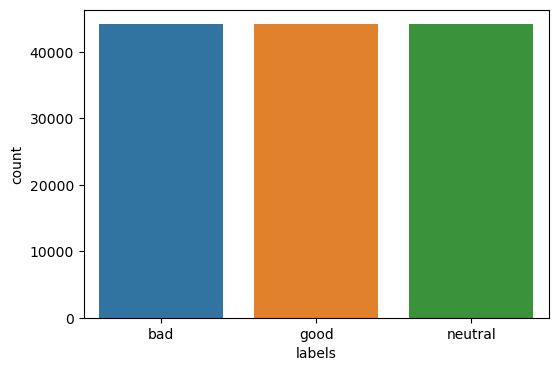

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='labels',data=y_train_res)

# TfidfVectorizer

In [19]:
stop_words = list(stopwords.words('english'))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features = 20000, analyzer = 'word',
                       stop_words = stop_words)

X_train_tf = vect.fit_transform(X_train_res['tweets_cleaned'])

X_test_tf = vect.transform(X_test['tweets_cleaned'])

In [21]:
X_train_res['tweets_cleaned'].head()

0    covering ai wild year ai beat venturebeatopena...
1    introducing aidle mashup word game wordle prom...
2    got point automated trope system typical regur...
3    world developer think used write develop devel...
4                                              ruining
Name: tweets_cleaned, dtype: object

In [22]:
# save the vectorizer with pickle
import pickle
filename = "../vectorizer/vectorizer.pickle" 

with open(filename, "wb") as file:
        pickle.dump(vect,file)

In [23]:
X_train_tf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
#vect.get_feature_names_out().tolist()

In [25]:
len(vect.get_feature_names_out())

20000

# Modelling

In [26]:
label_map = {
    'good':2,
    'neutral':1,
    'bad':0
}

df['labels'] = df['labels'].map(label_map)
df.head()

,labels,tweets_cleaned
0,1,optimizing language model dialogue openai
1,2,try talking new ai system optimized dialogue h...
2,1,optimizing language model dialogue ai machinel...
3,2,share new model optimized dialog public everyone
4,0,minute ago openai released new use right


## Random Forests

- Hyperparameter tuning

In [27]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):
 

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
grid = {'max_depth': [3,6,9],
        'n_estimators': [30,100,300]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = grid, cv = 5)
grid_search.fit(X_train_tf, y_train_res)

y_train_pred_rf = grid_search.predict(X_train_tf)
y_test_pred_rf  = grid_search.predict(X_test_tf)

model_performance_class(y_train_res, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.45
              precision    recall  f1-score   support

         bad       0.58      0.90      0.70     44124
        good       0.69      0.72      0.71     44124
     neutral       0.71      0.29      0.41     44124

    accuracy                           0.64    132372
   macro avg       0.66      0.64      0.61    132372
weighted avg       0.66      0.64      0.61    132372

Results obtained for the TEST SET
The Cohen's Kappa is: 0.48
              precision    recall  f1-score   support

         bad       0.71      0.90      0.79     20987
        good       0.65      0.70      0.67     11228
     neutral       0.61      0.26      0.37     10938

    accuracy                           0.69     43153
   macro avg       0.66      0.62      0.61     43153
weighted avg       0.67      0.69      0.66     43153



## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

grid_lr = {'C': np.logspace(-3, 1, 10),
          'penalty': ['l1','l2']}

lr = LogisticRegression()

grid_search_lr = GridSearchCV(estimator = lr, param_grid = grid_lr, cv = 5)

grid_search_lr.fit(X_train_tf, y_train_res)

y_train_pred_lr = grid_search_lr.predict(X_train_tf)
y_test_pred_lr  = grid_search_lr.predict(X_test_tf)

model_performance_class(y_train_res, y_train_pred_lr, y_test, y_test_pred_lr)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.70
              precision    recall  f1-score   support

         bad       0.80      0.90      0.85     44124
        good       0.83      0.80      0.82     44124
     neutral       0.76      0.70      0.73     44124

    accuracy                           0.80    132372
   macro avg       0.80      0.80      0.80    132372
weighted avg       0.80      0.80      0.80    132372

Results obtained for the TEST SET
The Cohen's Kappa is: 0.63
              precision    recall  f1-score   support

         bad       0.86      0.86      0.86     20987
        good       0.75      0.75      0.75     11228
     neutral       0.60      0.60      0.60     10938

    accuracy                           0.77     43153
   macro avg       0.74      0.74      0.74     43153
weighted avg       0.77      0.77      0.77     43153



In [30]:
filename = "../models/logistic_regression_model.pickle" 

with open(filename, "wb") as file:
        pickle.dump(grid_search_lr,file)

In [31]:
y_test_pred_lr = pd.DataFrame(y_test_pred_lr, columns=['labels'])

In [32]:
y_test_pred_lr['labels'].value_counts()

bad        21126
good       11080
neutral    10947
Name: labels, dtype: int64

In [33]:
y_test_pred_lr.head()

,labels
0,neutral
1,good
2,good
3,bad
4,bad


## Naive Bayers

In [34]:
from sklearn.naive_bayes import MultinomialNB

grid_nb = {'alpha': [0,0.3,0.7,1]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb, param_grid = grid_nb, cv = 5)


grid_search_nb.fit(X_train_tf, y_train_res)

y_train_pred_nb = grid_search_nb.predict(X_train_tf)
y_test_pred_nb = grid_search_nb.predict(X_test_tf)

model_performance_class(y_train_res, y_train_pred_nb, y_test, y_test_pred_nb)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.54
              precision    recall  f1-score   support

         bad       0.79      0.73      0.76     44124
        good       0.66      0.78      0.71     44124
     neutral       0.64      0.58      0.61     44124

    accuracy                           0.70    132372
   macro avg       0.70      0.70      0.69    132372
weighted avg       0.70      0.70      0.69    132372

Results obtained for the TEST SET
The Cohen's Kappa is: 0.43
              precision    recall  f1-score   support

         bad       0.84      0.66      0.74     20987
        good       0.54      0.71      0.61     11228
     neutral       0.45      0.48      0.47     10938

    accuracy                           0.63     43153
   macro avg       0.61      0.62      0.61     43153
weighted avg       0.66      0.63      0.64     43153



# Model comparison

In [35]:
kappa_train_rf = cohen_kappa_score(y_train_res, y_train_pred_rf)
kappa_train_lr = cohen_kappa_score(y_train_res, y_train_pred_lr)
kappa_train_nb = cohen_kappa_score(y_train_res, y_train_pred_nb)

In [36]:
kappa_train_rf

0.45414060375305954

In [37]:
kappa_test_rf = cohen_kappa_score(y_test, y_test_pred_rf)
kappa_test_lr = cohen_kappa_score(y_test, y_test_pred_lr)
kappa_test_nb = cohen_kappa_score(y_test, y_test_pred_nb)

In [38]:
train_metrics = [kappa_train_rf, kappa_train_lr, kappa_train_nb]
test_metrics = [kappa_test_rf, kappa_test_lr, kappa_test_nb]
model_names = ["RF", "LR", "NB"]
model_eval= pd.DataFrame(data = zip(model_names, train_metrics, test_metrics), columns=["model", "train", "test"])
model_eval

,model,train,test
0,RF,0.454141,0.477645
1,LR,0.698690,0.630909
2,NB,0.543140,0.433154


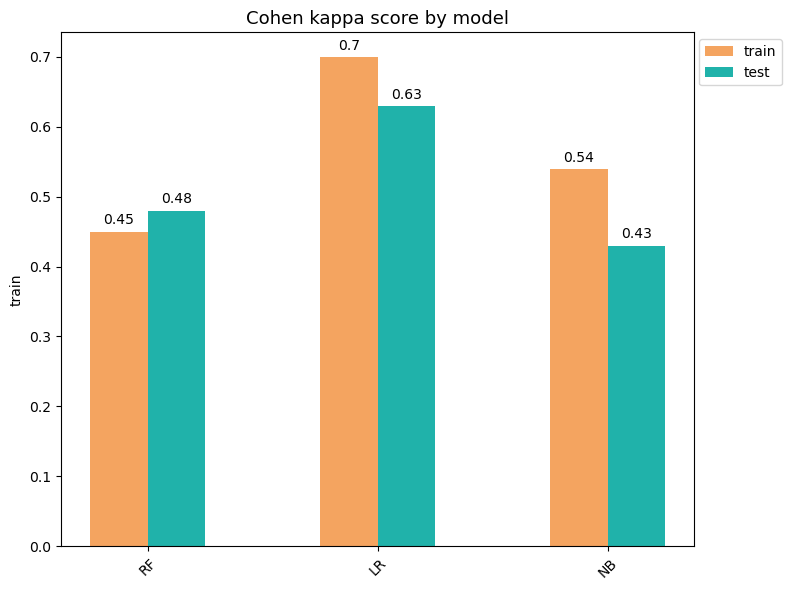

In [39]:
def plot_eval_metrics(model, train_list, test_list):
    x = np.arange(len(model_names))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,6))
    rects1 = ax.bar(x - width/2, [round(train,2) for train in train_list], width, label='train', color="sandybrown")
    rects2 = ax.bar(x + width/2, [round(test, 2) for test in test_list], width, label='test', color="lightseagreen")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('train')
    ax.set_title('Cohen kappa score by model', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(loc="upper right", bbox_to_anchor=(1.15,1))

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

plot_eval_metrics(model_names, train_metrics,test_metrics)

- Comparing the model performance score for all three models, the prediction performance of logistic regression model is better than the other two when dealing with ChatGPT sentiment analysis.